# Testing best LBFGS parameters

In [1]:
import os
os.chdir("../")

In [2]:

from fastqaoa.ctypes.optimize import optimize_qaoa_lbfgs
from fastqaoa.ctypes import Diagonals
from fastqaoa import params

from problems.integer_knapsack import IntegerKnapsack

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

In [4]:
import pandas as pd
import seaborn as sns
import time

In [238]:
ps = [1, 2, 4, 8, 16]
ms = [100]
ls = [0]
mis = [100]

np.random.seed(210309429)
instances = [Diagonals.from_numpy(np.random.randn(1 << 12)) for i in range(64)]


In [239]:
problems = IntegerKnapsack.get_instances()[18][:64]
instances2 = [i.masked_cost() for i in problems]
instances = []
for dg in instances2:
    scale = max(abs(dg.min_val), abs(dg.max_val))
    instances.append((dg, dg * dg.n_qubits / scale))

In [240]:
results = []

tpe = ThreadPoolExecutor(max_workers=4)

def inner(i):
    results = []
    for m in ms:
        for l in ls:
            for mi in mis:
                betas = 0.1 * np.ones(1)
                gammas = 0.1 * np.ones(1)
                for p in ps:
                    c, d = instances[i]
                    betas, gammas = params.interpolate(p, betas, gammas)
                    a = time.time()
                    res = optimize_qaoa_lbfgs(d, c, betas, gammas, tol=1e-1, linesearch=l, m=m, maxiter=mi)
                    rt = time.time() - a
                    results.append({"instance": i, "depth": p, "m": m, "linesearch": l, "runtime": rt, "maxiter": mi, **res._asdict()})
    return results

for res in tqdm(tpe.map(inner, range(len(instances))), total=len(instances)):
    results += res

 33%|████████████████████▋                                          | 21/64 [05:15<10:46, 15.04s/it]


KeyboardInterrupt: 

In [241]:
df = pd.DataFrame(results)

In [242]:
df.status = df.status.transform(lambda x: x.value)
df.to_feather("notebooks/lbfgs_parameters.feather")

In [243]:
df = pd.read_feather("notebooks/lbfgs_parameters.feather")

In [244]:
df = df.query("it > 0")

In [245]:
df["final"] = df.log.transform(lambda x: x[-1])
df["relative"] = df.apply(lambda r: r.final / instances2[r.instance].min_val, axis=1)

In [246]:
styles = ["-", "--", "-.", ":", "-", "--"]
colors = sns.color_palette("coolwarm", len(ms))

for i, r in df.query("instance == 58").iterrows():
    plt.plot(r.log, linestyle=styles[mis.index(r.maxiter)], alpha=0.2, color=colors[ms.index(r.m)])

<Axes: xlabel='calls', ylabel='Count'>

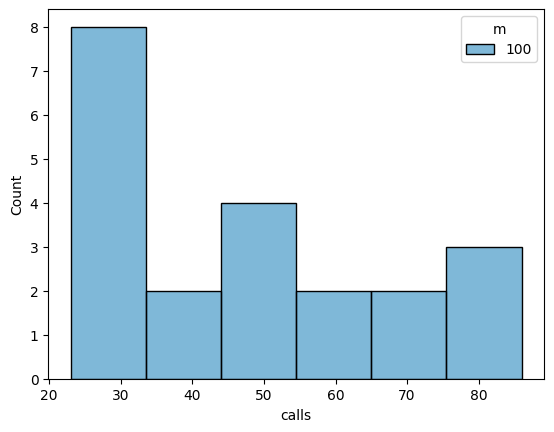

In [247]:
sns.histplot(df.query("depth==4"), x="calls", hue="m", alpha=0.5, palette="colorblind")

<Axes: xlabel='relative', ylabel='calls'>

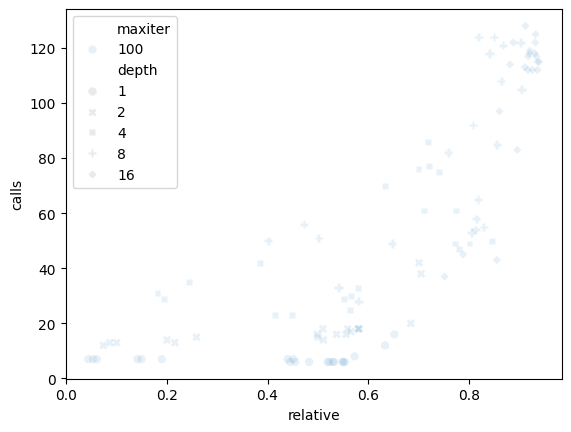

In [248]:
sns.scatterplot(df.query("m == 100"), x="relative", y="calls", hue="maxiter", style="depth", palette="tab10", alpha=0.1)

<Axes: xlabel='calls', ylabel='runtime'>

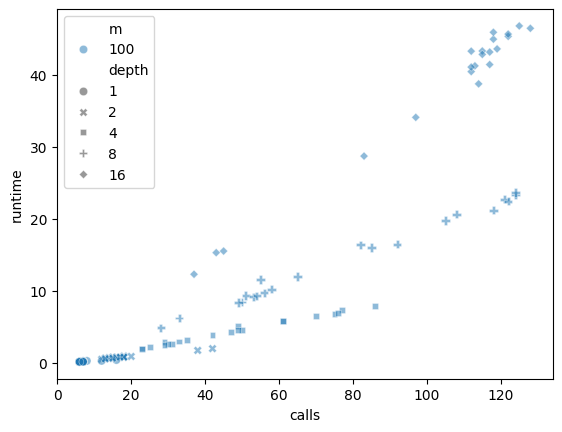

In [249]:
sns.scatterplot(df, x="calls", y="runtime", style="depth", hue="m", palette="tab10", alpha=0.5)

<Axes: xlabel='depth', ylabel='relative'>

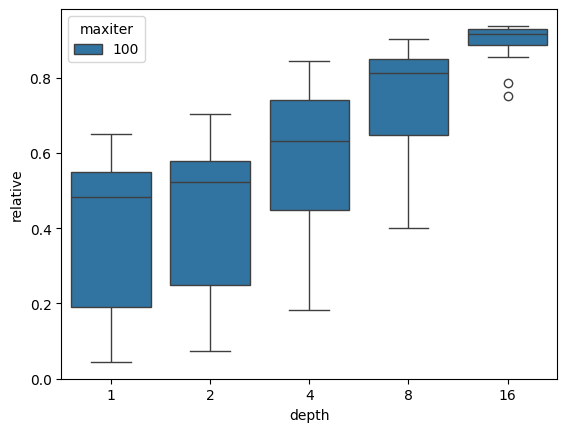

In [250]:
sns.boxplot(df, x="depth", y="relative", hue="maxiter", palette="tab10")

<Axes: xlabel='maxiter', ylabel='calls'>

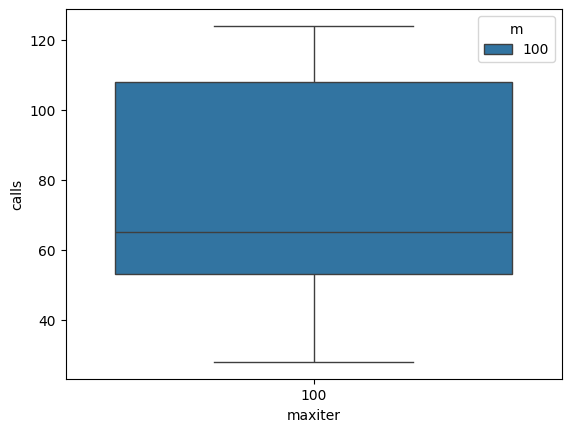

In [251]:
sns.boxplot(df.query("depth==8"), x="maxiter", y="calls", hue="m", palette="tab10")

In [ ]:
pd.concat(srs, axis=1)

In [ ]:
colors = sns.color_palette("coolwarm", )
colors

## Main Verdicts
- Use `m = 100` as it reduces the amount of function calls
- Linesearch types do not make a large difference (Except for `linesearch = 1` wich causes reduced runtime but also worse performance)
- Tolerance does not need to be low (somehow tolerance of 0.1) provided the best results w.r.t solution quality
- Number of iterations should be definetily be capped to a max of 100. Above that the increased runtime gives diminishing returns